# NLIP. Home assignment 4.                                  Zhanna Azizova

Data:
https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/overview

**Task:**

1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline; Please compare word-embeddings vs classical methods 
3. Tune  your model

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import itertools
import keras
import multiprocessing

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.backend import floatx
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Activation, Input, Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB

In [6]:
def plot_confusion_matrix(Y_test, y_pred, classes, title):
    cm = confusion_matrix(y_test,y_pred)
    np.set_printoptions(precision=2)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
data = pd.read_csv('train.tsv', sep='\t')

In [8]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
data.shape

(156060, 4)

In [10]:
data['Sentiment'].value_counts(normalize = True)*100

2    50.994489
3    21.098936
1    17.475971
4     5.899013
0     4.531590
Name: Sentiment, dtype: float64

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

**As we can see the classess in the sample are imbalanced (especially negative and positive)**

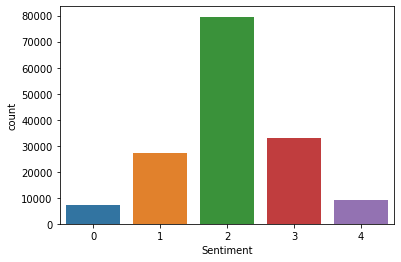

In [11]:
sns.countplot(data['Sentiment'])


## Metric for quality

If choosing the only one, the best choices as metrics for quality evaluation for multiclass classification models is: ** f1 score**. F1-score takes into account both recall and precsision that means that it evaluates how well model distinguishes between all classes.

F1 Score: It is a harmonic mean of precision and recall given by- 
F1 = 2*Precision*Recall/(Precision + Recall).

Since samples of some classes are imbalanced I would choose **macro average f1-score.**

## Data processing and feature extraction 

Preprocessing of phrases is done as follows:
-  All words(tokens) are converted to lower case
-  Punctuation marks are removed from the phrase.
-  The phrase is splitted into tokens(words) from whitespace characters.
-  Stop words are filtered with the help of stop word dictionary of NLTK library.
-  Each token is replaced with its word stem with the help of SnowballStemmer library of NLTK.


After preprocessing step, vocabulary is built from these tokens. 

In [12]:
stops = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    words = letters_only.lower().split()
    meaningful_words = [stemmer.stem(w) for w in words if w not in stops]
    return( " ".join( meaningful_words ))

In [13]:
data['Words'] = data['Phrase'].apply(review_to_words)

## Pipeline building, modeling, model evaluation and tuning

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['Words'], data['Sentiment'], test_size=0.2, random_state=42)

In [57]:
print('Train sample shape:', X_train.shape)
print('Test sample shape:', X_test.shape)

Train sample shape: (124848,)
Test sample shape: (31212,)


### Word embeddings in Keras

In [58]:
maxlen = 125
max_words = 5000
num_classes = 5

In [59]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = tokenizer.texts_to_sequences(X_test)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_val = keras.utils.to_categorical(y_test, num_classes)

In [60]:
emb_model = Sequential()


emb_model.add(Embedding(max_words,100,mask_zero=True))
emb_model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
emb_model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
emb_model.add(Dense(5,activation='softmax'))
emb_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total params: 554,821
Trainable params: 554,821
Non-trainable params: 0
_________________________________________________________________


In [61]:
epochs = 5
batch_size = 32
emb_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
emb_model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 112363 samples, validate on 12485 samples
Epoch 1/5
112363/112363 [==============================] - 917s 8ms/step - loss: 1.0497 - acc: 0.5924 - val_loss: 0.9240 - val_acc: 0.6346
Epoch 2/5
112363/112363 [==============================] - 919s 8ms/step - loss: 0.9022 - acc: 0.6370 - val_loss: 0.8974 - val_acc: 0.6388
Epoch 3/5
112363/112363 [==============================] - 915s 8ms/step - loss: 0.8609 - acc: 0.6509 - val_loss: 0.8823 - val_acc: 0.6465
Epoch 4/5
112363/112363 [==============================] - 925s 8ms/step - loss: 0.8322 - acc: 0.6608 - val_loss: 0.8724 - val_acc: 0.6481
Epoch 5/5
112363/112363 [==============================] - 918s 8ms/step - loss: 0.8077 - acc: 0.6702 - val_loss: 0.8715 - val_acc: 0.6481


In [62]:
score = emb_model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

31212/31212 [==============================] - 58s 2ms/step


Test score: 0.8679424041236927
Test accuracy: 0.6516083557606049


In [63]:
y_pred = emb_model.predict_classes(X_val, batch_size=batch_size)

In [64]:
labels = ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']
print(classification_report(y_test, y_pred, target_names = labels))

                   precision    recall  f1-score   support

         negative       0.56      0.33      0.41      1416
somewhat negative       0.55      0.47      0.51      5527
          neutral       0.73      0.80      0.76     15639
somewhat positive       0.56      0.59      0.57      6707
         positive       0.56      0.41      0.47      1923

         accuracy                           0.65     31212
        macro avg       0.59      0.52      0.55     31212
     weighted avg       0.64      0.65      0.64     31212



### Keras standart model with texts to matrix

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data['Words'], data['Sentiment'], test_size=0.2, random_state=42)

In [70]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [71]:
x_train_bin = tokenizer.texts_to_matrix(X_train, mode='binary')
x_test_bin = tokenizer.texts_to_matrix(X_test, mode='binary')

In [72]:
y_train_bin = keras.utils.to_categorical(y_train, num_classes)
y_test_bin = keras.utils.to_categorical(y_test, num_classes)

In [73]:
# Building Keras model 
model = Sequential([Dense(512, input_shape=(max_words,)),
                      Activation('relu'),
                      Dropout(0.5),
                      Dense(num_classes),
                      Activation('softmax')])

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
batch_size = 32
epochs = 10
history = model.fit(x_train_bin, y_train_bin,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 99878 samples, validate on 24970 samples
Epoch 1/10
99878/99878 [==============================] - 50s 505us/step - loss: 1.0005 - acc: 0.6046 - val_loss: 0.9075 - val_acc: 0.6340
Epoch 2/10
99878/99878 [==============================] - 49s 489us/step - loss: 0.8527 - acc: 0.6615 - val_loss: 0.8862 - val_acc: 0.6490
Epoch 3/10
99878/99878 [==============================] - 49s 490us/step - loss: 0.7931 - acc: 0.6889 - val_loss: 0.8871 - val_acc: 0.6536
Epoch 4/10
99878/99878 [==============================] - 49s 492us/step - loss: 0.7504 - acc: 0.7054 - val_loss: 0.8927 - val_acc: 0.6575
Epoch 5/10
99878/99878 [==============================] - 48s 483us/step - loss: 0.7171 - acc: 0.7199 - val_loss: 0.9059 - val_acc: 0.6587
Epoch 6/10
99878/99878 [==============================] - 48s 484us/step - loss: 0.6918 - acc: 0.7309 - val_loss: 0.9191 - val_acc: 0.6585
Epoch 7/10
99878/99878 [==============================] - 49s 489us/step - loss: 0.6708 - acc: 0.7392 - val_loss: 0.

In [76]:
score = model.evaluate(x_test_bin, y_test_bin,batch_size=batch_size)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

31212/31212 [==============================] - 3s 89us/step


Test score: 0.9872797035214597
Test accuracy: 0.6546520568973725


In [78]:
y_pred = model.predict_classes(x_test_bin, batch_size=batch_size)

In [79]:
print(classification_report(y_test, y_pred, target_names = labels))

                   precision    recall  f1-score   support

         negative       0.54      0.32      0.40      1416
somewhat negative       0.57      0.44      0.50      5527
          neutral       0.70      0.85      0.77     15639
somewhat positive       0.59      0.52      0.56      6707
         positive       0.57      0.36      0.44      1923

         accuracy                           0.65     31212
        macro avg       0.59      0.50      0.53     31212
     weighted avg       0.64      0.65      0.64     31212



### Multinomial NB with Count Vectorizer

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data['Words'], data['Sentiment'], test_size=0.2, random_state=42)

In [83]:
count_vectorizer = CountVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_cv_nb_pipeline = Pipeline([('vectorizer', count_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_cv_nb_param_grid = [
    {   'vectorizer__min_df': [ 1, 2, 3],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5]}]

In [88]:
# Perform grid search
mn_cv_nb_gs = GridSearchCV(estimator=mn_cv_nb_pipeline, param_grid=mn_cv_nb_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=multiprocessing.cpu_count())
mn_cv_nb_gs.fit(X_train, y_train)

# Create an instance of the best estimator
mn_cv_nb_best = mn_cv_nb_gs.best_estimator_
mn_cv_nb_best.fit(X_train, y_train)

print('Best model: %s' % str(mn_cv_nb_gs.best_params_))
print('Best f1 score: %f' % mn_cv_nb_gs.best_score_)
print('Best test f1 score: %f' % mn_cv_nb_best.score(X_test, y_test))

Best model: {'multinomial_nb__alpha': 0.5, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best f1 score: 0.501602
Best test f1 score: 0.605761


### Multinomial NB with Tf-Idf Vectorizer

In [102]:
tfidf_vectorizer = TfidfVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_tfidfv_nb_pipeline = Pipeline([('vectorizer', tfidf_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_tfidfv_nb_param_grid = [
    {   'vectorizer__min_df': [ 1, 2, 3],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3)],
        'vectorizer__norm': [ None, 'l1', 'l2' ],
        'multinomial_nb__alpha': [0.25, 0.5]}]

# Perform grid search
mn_tfidfv_nb_gs = GridSearchCV(estimator=mn_tfidfv_nb_pipeline, param_grid=mn_tfidfv_nb_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=multiprocessing.cpu_count())
mn_tfidfv_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [103]:
# Create an instance of the best estimator
mn_tfidfv_nb_best = mn_tfidfv_nb_gs.best_estimator_
mn_tfidfv_nb_best.fit(X_train, y_train)

print('Best model: %s' % str(mn_tfidfv_nb_gs.best_params_))
print('Best f1 score: %f' % mn_tfidfv_nb_gs.best_score_)
print('Best test f1 score: %f' % mn_tfidfv_nb_best.score(X_test, y_test))

Best model: {'multinomial_nb__alpha': 0.25, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 3), 'vectorizer__norm': 'l2'}
Best f1 score: 0.490842
Best test f1 score: 0.644175


In [120]:
mn_tfidfv_nb_pred = mn_tfidfv_nb_best.predict(X_test)
print(classification_report(y_test, mn_tfidfv_nb_pred, target_names = labels))

                   precision    recall  f1-score   support

         negative       0.53      0.31      0.39      1416
somewhat negative       0.55      0.48      0.51      5527
          neutral       0.71      0.82      0.76     15639
somewhat positive       0.57      0.52      0.54      6707
         positive       0.56      0.34      0.42      1923

         accuracy                           0.64     31212
        macro avg       0.58      0.49      0.53     31212
     weighted avg       0.63      0.64      0.63     31212



### LinearSVC with Count Vectorizer

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data['Words'], data['Sentiment'], test_size=0.2, random_state=42)

In [15]:
count_vectorizer = CountVectorizer(binary=True)
svm = LinearSVC()

# Define pipeline
svm_pipeline = Pipeline([('vectorizer', count_vectorizer),
                             ('linearSVC', svm)])

# Grid search parameters
svm_param_grid = [
    {   'vectorizer__min_df': [ 1, 2, 3],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3) ],
        'linearSVC__C': [0.001, 0.005, 0.01, 0.05, 0.1]}]

svm_gs = GridSearchCV(estimator=svm_pipeline, param_grid=svm_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=1)

svm_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                       

In [16]:
svm_gs_best = svm_gs.best_estimator_
svm_gs_best.fit(X_train, y_train)

print('Best model: %s' % str(svm_gs.best_params_))
print('Best f1 score: %f' % svm_gs.best_score_)
print('Best test f1 score: %f' % svm_gs.score(X_test, y_test))

Best model: {'linearSVC__C': 0.1, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 3)}
Best f1 score: 0.516661
Best test f1 score: 0.538239


In [19]:
svm_gs_pred = svm_gs_best.predict(X_test)
print(classification_report(y_test, svm_gs_pred, target_names = labels))

                   precision    recall  f1-score   support

         negative       0.51      0.36      0.42      1416
somewhat negative       0.58      0.43      0.50      5527
          neutral       0.70      0.87      0.78     15639
somewhat positive       0.61      0.49      0.54      6707
         positive       0.55      0.39      0.46      1923

         accuracy                           0.66     31212
        macro avg       0.59      0.51      0.54     31212
     weighted avg       0.64      0.66      0.64     31212



## Conclusion

**The best macro average F1 score (0.55) was reached by Keras model with word embeddings. However, overall the difference between models' performances is not sufficient.**